In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sqlite3
from sqlalchemy import create_engine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

con = sqlite3.connect("/content/gdrive/My Drive/Colab Notebooks/wildfires.sqlite")

In [12]:
CATEGORICAL = ["NWCG_REPORTING_AGENCY", "FIRE_SIZE_CLASS", "STATE"]
NUMERICAL = ["FIRE_YEAR", "DISCOVERY_DOY", "DISCOVERY_DATE", "STAT_CAUSE_CODE", "CONT_DOY", "CONT_DATE", "FIRE_SIZE", "LATITUDE", "LONGITUDE", "OWNER_CODE"]
fires_table = pd.read_sql_query("SELECT * from Fires", con)
wildfires = fires_table[NUMERICAL + CATEGORICAL]

In [13]:
wildfires.size

24446045

In [40]:
large_wildfires = wildfires.loc[wildfires["FIRE_SIZE"] > 10]
large_wildfires.size

3106415

In [46]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
d = defaultdict(LabelEncoder)

# Encoding the variable
large_wildfires = large_wildfires.apply(lambda x: d[x.name].fit_transform(x))

# # Inverse the encoded
# fit.apply(lambda x: d[x.name].inverse_transform(x))

# # Using the dictionary to label future data
# df.apply(lambda x: d[x.name].transform(x))

In [54]:
from sklearn.model_selection import train_test_split

x = large_wildfires.drop("FIRE_SIZE_CLASS", 1)
X_train, X_test, y_train, y_test = train_test_split(x, large_wildfires["FIRE_SIZE_CLASS"], test_size=0.2, random_state=15)

In [59]:
X_train.size, y_train.size

(2293968, 191164)

As a baseline classifier, we simply assign the most common fire size class to each fire. Our models must improve upon this number.

In [60]:
large_wildfires["FIRE_SIZE_CLASS"].value_counts().max() / large_wildfires["FIRE_SIZE_CLASS"].size

0.7736268335042162

In [61]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

[Text(95.65714285714286, 195.696, 'X[6] <= 3767.5\ngini = 0.382\nsamples = 191164\nvalue = [147946, 22690, 11304, 6227, 2997]'),
 Text(47.82857142857143, 152.208, 'gini = 0.0\nsamples = 147946\nvalue = [147946, 0, 0, 0, 0]'),
 Text(143.4857142857143, 152.208, 'X[6] <= 5113.0\ngini = 0.63\nsamples = 43218\nvalue = [0, 22690, 11304, 6227, 2997]'),
 Text(95.65714285714286, 108.72, 'gini = 0.0\nsamples = 22690\nvalue = [0, 22690, 0, 0, 0]'),
 Text(191.31428571428572, 108.72, 'X[6] <= 6515.5\ngini = 0.583\nsamples = 20528\nvalue = [0, 0, 11304, 6227, 2997]'),
 Text(143.4857142857143, 65.232, 'gini = 0.0\nsamples = 11304\nvalue = [0, 0, 11304, 0, 0]'),
 Text(239.14285714285714, 65.232, 'X[6] <= 9250.5\ngini = 0.439\nsamples = 9224\nvalue = [0, 0, 0, 6227, 2997]'),
 Text(191.31428571428572, 21.744, 'gini = 0.0\nsamples = 6227\nvalue = [0, 0, 0, 6227, 0]'),
 Text(286.9714285714286, 21.744, 'gini = 0.0\nsamples = 2997\nvalue = [0, 0, 0, 0, 2997]')]

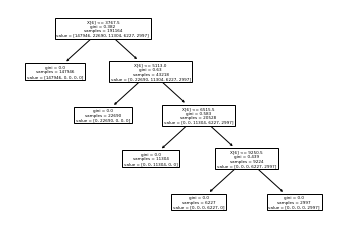

In [62]:
tree.plot_tree(clf) 

In [70]:
pred = clf.predict(X_test)

In [71]:
np.mean(pred != y_test)

0.0